In [598]:
import pandas as pd
import pandasql
import numpy as np
from pandasql import sqldf
import sqlite3
from matplotlib import pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup as bs
import requests
pysqldf = lambda q: sqldf(q, globals())

In [599]:
bom_df = pd.read_csv("data/bom.movie_gross.csv")
tn_df = pd.read_csv("data/tn.movie_budgets.csv")
rt_movies = pd.read_csv("data/rt.movie_info.tsv", delimiter="\t")
rt_reviews = pd.read_csv("data/rt.reviews.tsv", delimiter="\t")
tmdb_df = pd.read_csv("data/tmdb.movies.csv")
tn_df = pd.read_csv("data/tn.movie_budgets.csv")

new_movie_basics = pd.read_csv("data/new_movie_basics.tsv", delimiter="\t")

conn = sqlite3.connect("data/im.db")
imdb_tables = pd.read_sql("""
SELECT name FROM sqlite_master
    WHERE type='table'
""", conn)

movie_basics = pd.read_sql(""" SELECT * FROM movie_basics """, conn)
directors = pd.read_sql(""" SELECT * FROM directors """, conn)
known_for = pd.read_sql(""" SELECT * FROM known_for """, conn)
movie_akas = pd.read_sql(""" SELECT * FROM movie_akas """, conn)
movie_ratings = pd.read_sql(""" SELECT * FROM movie_ratings """, conn)
persons = pd.read_sql(""" SELECT * FROM persons """, conn)
principals = pd.read_sql(""" SELECT * FROM principals """, conn)
writers = pd.read_sql(""" SELECT * FROM writers """, conn)

/var/folders/s6/jlb2zd1s5gq39tnl2x_y5z_r0000gn/T/ipykernel_98258/1684874425.py:8: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  new_movie_basics = pd.read_csv("data/new_movie_basics.tsv", delimiter="\t")


# Combining movie, genre, budget, gross, and ROI data

In order to perform our analyses, we will need to combine data from the IM.DB database (which contains genre data), box office mojo (which contains studio data), and The Numbers (which contains budget and gross data). Our dataset will be smaller than any one of the original datasets, but this is the only way to conduct our analyses.

In [600]:
def money_to_int(x):
    x = x[1:]
    split = x.split(",")
    joined = "".join(split)
    integer = int(joined)
    return integer

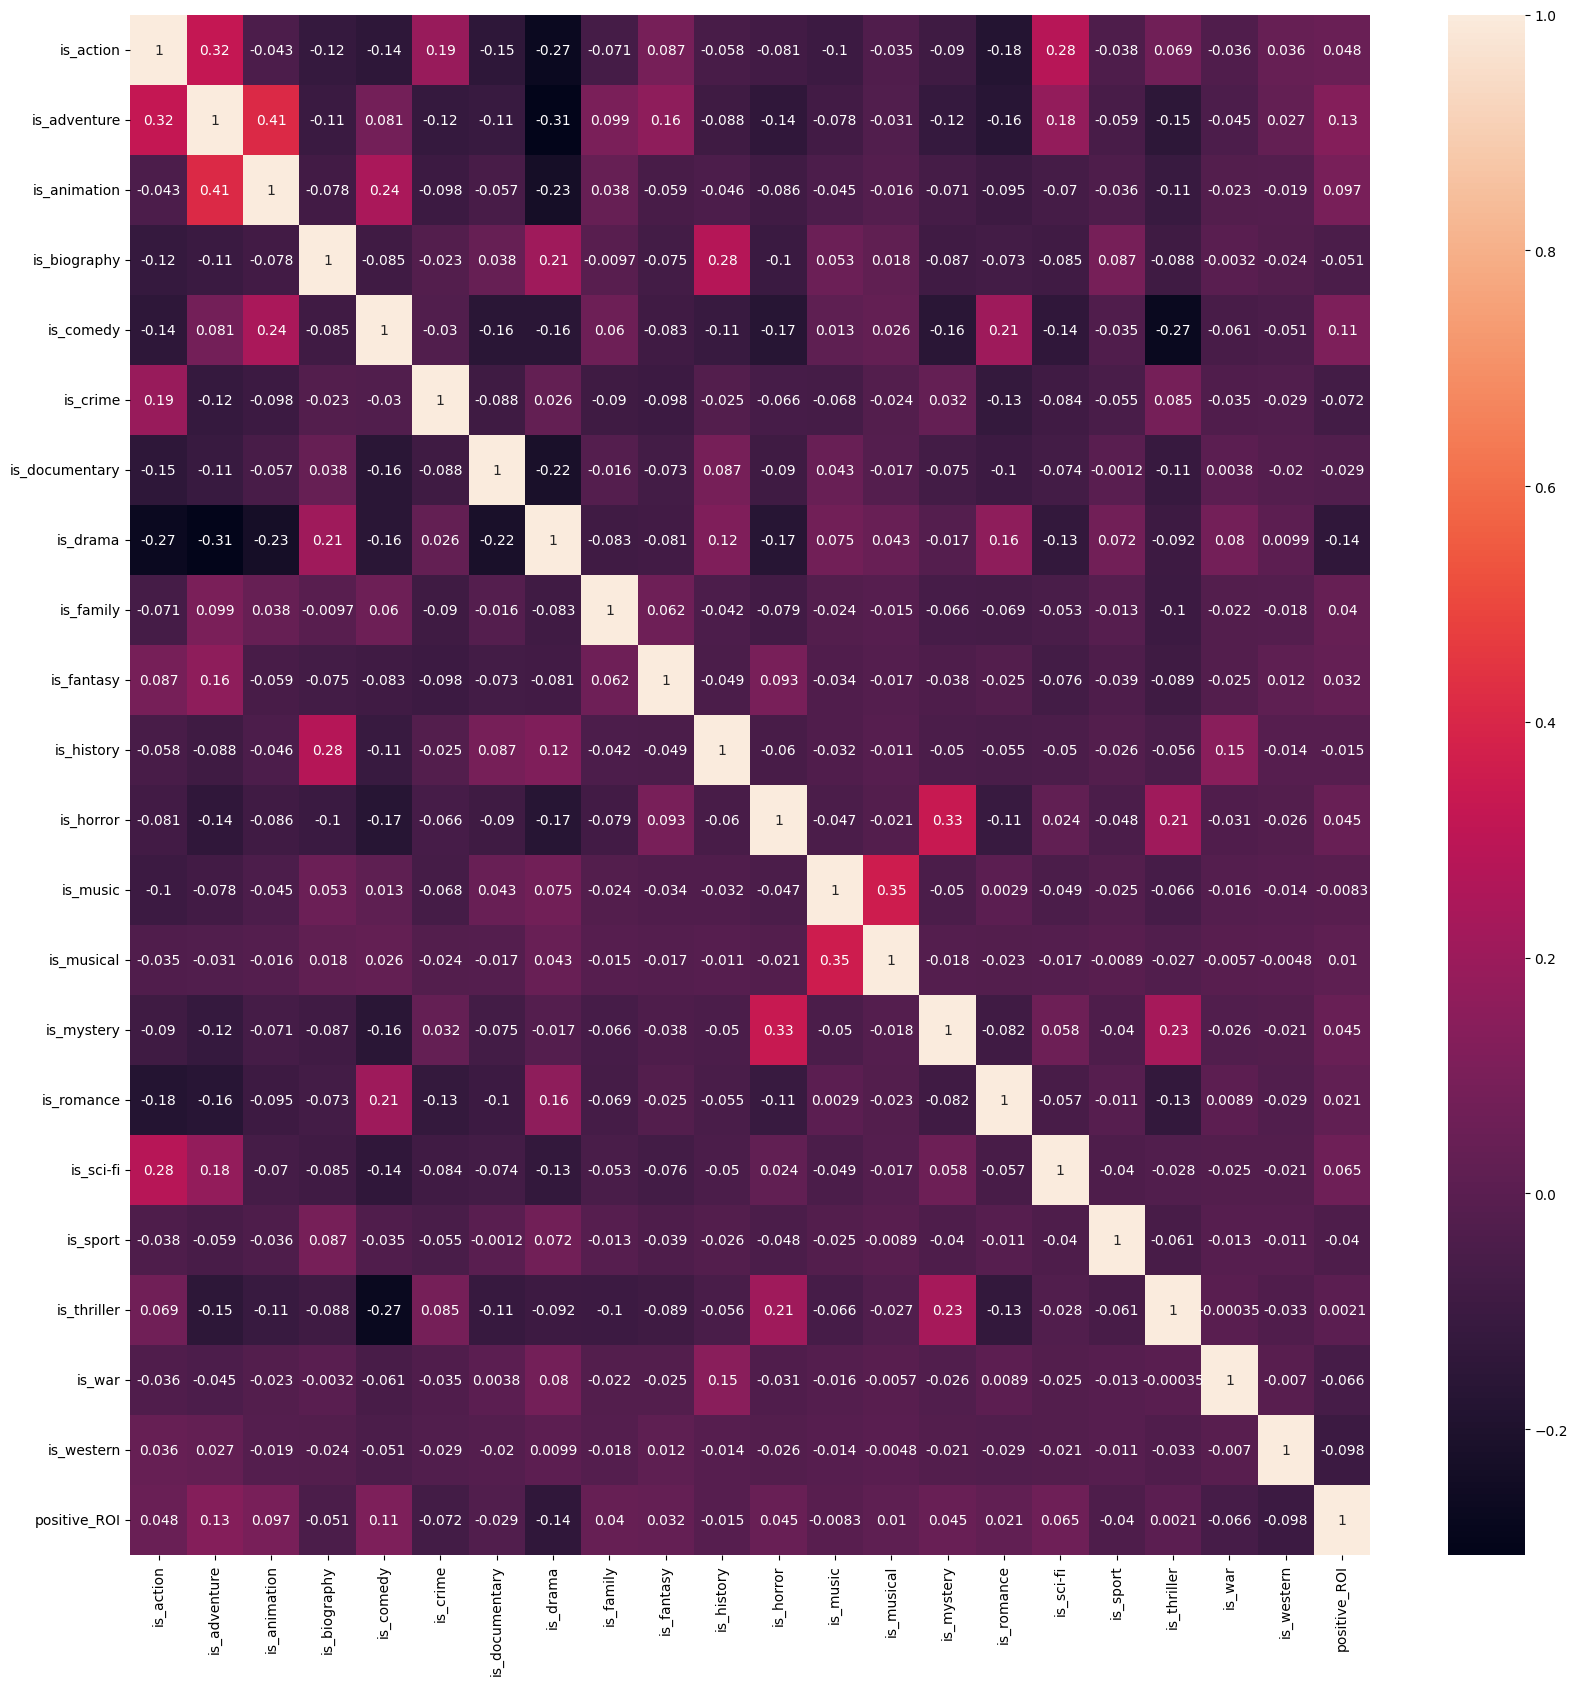

In [653]:
genres = ["action", "adventure", "animation", "biography", "comedy",
          "crime", "documentary", "drama", "family", "fantasy", "film-noir", "history",
          "horror", "music", "musical", "mystery", "romance", "sci-fi", "short", "sport",
          "superhero", "thriller", "war", "western"]
    
q = """
SELECT movie_basics.movie_id,
       bom_df.year,
       bom_df.studio,
       bom_df.title,
       movie_basics.runtime_minutes,
       movie_basics.genres,
       tn_df.domestic_gross,
       tn_df.worldwide_gross,
       tn_df.production_budget

FROM tn_df
JOIN bom_df
    ON title = movie
JOIN movie_basics
    ON title = primary_title
"""

df = pysqldf(q)

# Changing budget and gross columns to integer types
df['production_budget'] = df['production_budget'].map(lambda x: money_to_int(x))
df['domestic_gross'] = df['domestic_gross'].map(lambda x: money_to_int(x))
df['worldwide_gross'] = df['worldwide_gross'].map(lambda x: money_to_int(x))

# Creating new columns
df['foreign_gross'] = df['worldwide_gross'] - df['domestic_gross']
df['ROI'] = round((df['worldwide_gross'] / df['production_budget'])*100, 2)
df['positive_ROI'] = df['ROI'].map(lambda x: True if x>100 else False)

# Elminating null values
df['genres'] = df['genres'].map(lambda x: 'None' if not x else x)
df['genres'] = df['genres'].map(lambda x: x.lower())

for i in genres:
    df["is_"+i.lower()] = df['genres'].map(lambda x: True if i in x else False)

q = """
SELECT * FROM df
WHERE movie_id NOT IN (SELECT movie_id
                       FROM df
                       GROUP BY movie_id
                       HAVING COUNT(*)>=2)
"""

df = pysqldf(q)

# for i in list(range(12, 36)):
#     if df.iloc[:, i].value_counts()[False] == 1546:
#         print(df.iloc[:, i].value_counts())

df.drop(['is_film-noir', 'is_short', 'is_superhero'], axis=1, inplace=True)
genres = [i for i in genres if i not in['film-noir', 'short', 'superhero']]

corr = df.iloc[:, 12:].copy()
corr['positive_ROI'] = my_df['positive_ROI']

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr.corr(), ax=ax, annot=True);

# Conclusion

There aren't any striking correlations between genre and ROI. In fact, the most powerful correlation are ones between genres themselves. For example, adventure has a moderate correlation with action and adventure has a similar correlation with animation.

Adventure, animation and comedy have the strongest correlations with whether or not a movie is profitable. Horror, mystery and thriller have the strongest correlations with ROI.

What if certain combinations of genres have greater correlations with ROI? To find out, I have selected some of the most frequently seen genre combinations in our dataset, created new columns in the dataframe, and created another heatmap.

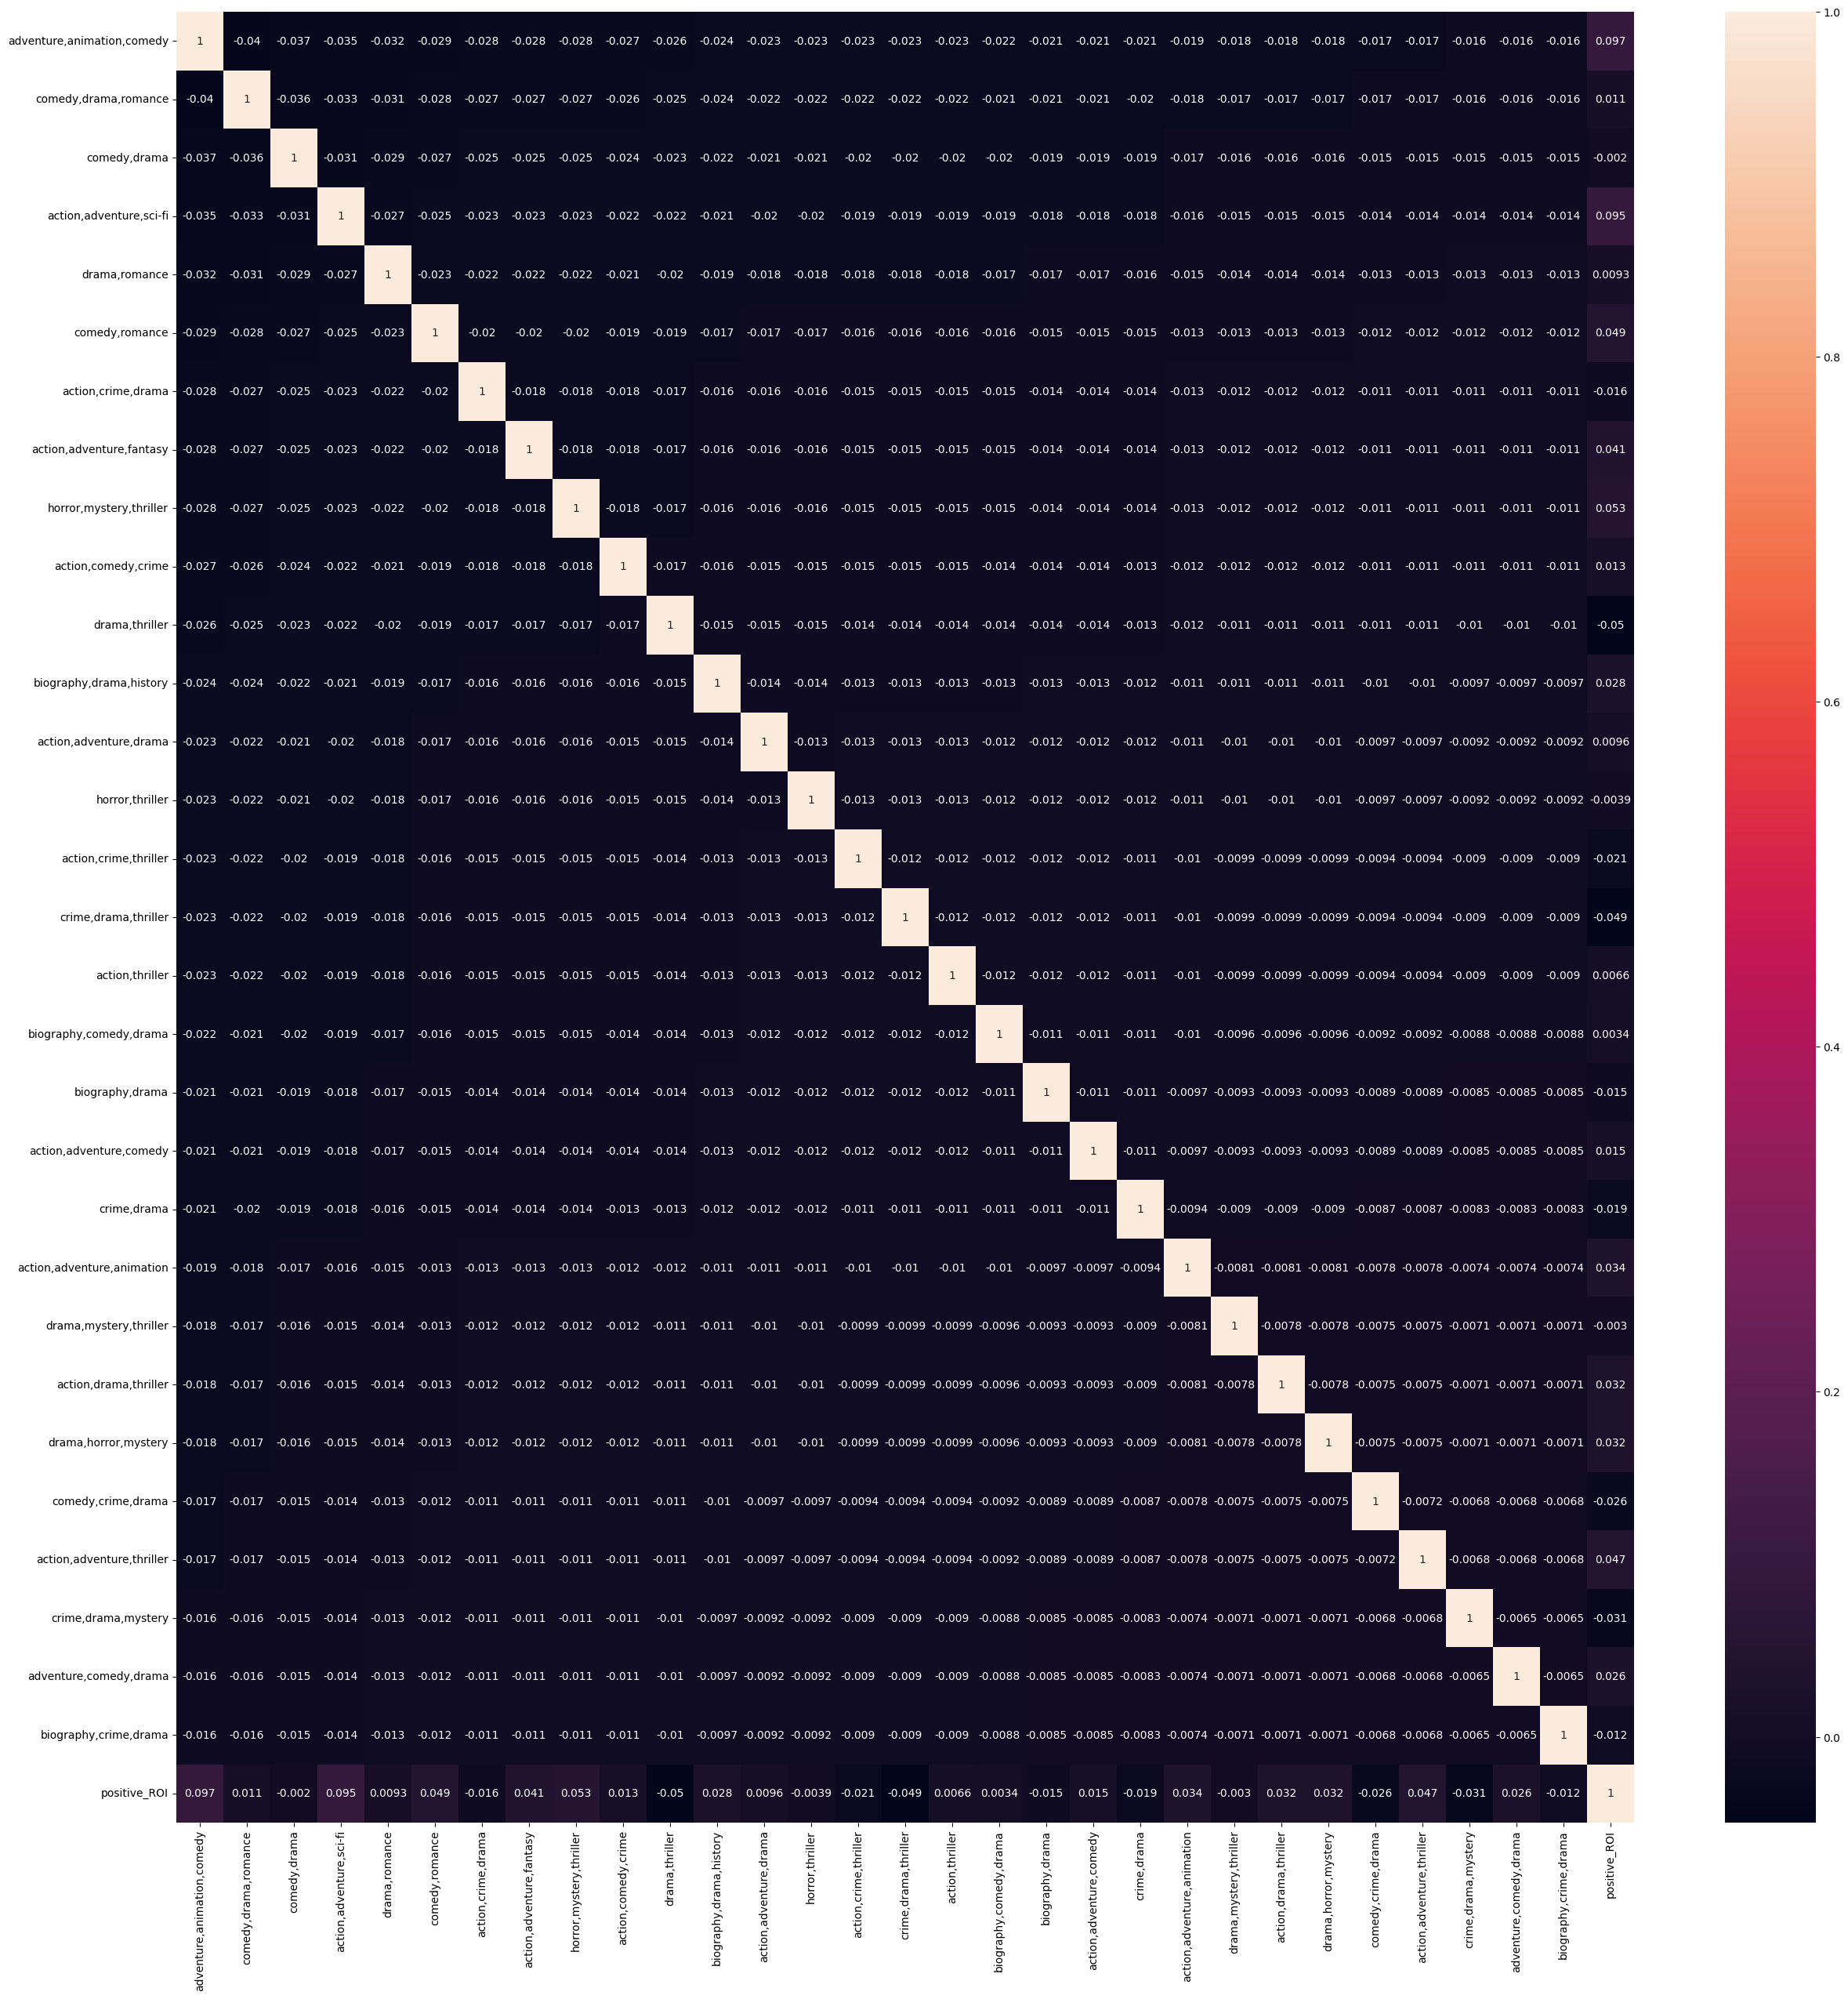

In [603]:
combinations = {key: value for key, value in dict(df.genres.value_counts()).items() if ((value >= 10) & (len(key.split(","))>1))}

for i in combinations.keys():
    df[i] = df.genres.map(lambda x: True if x == i else False)

corr = df.iloc[:, 33:].copy()
corr['positive_ROI'] = my_df['positive_ROI']

fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corr.corr(), ax=ax, annot=True);

# ROI with or without the presence of a genre

For example, action movies are 53% less profitable than non-action movies.

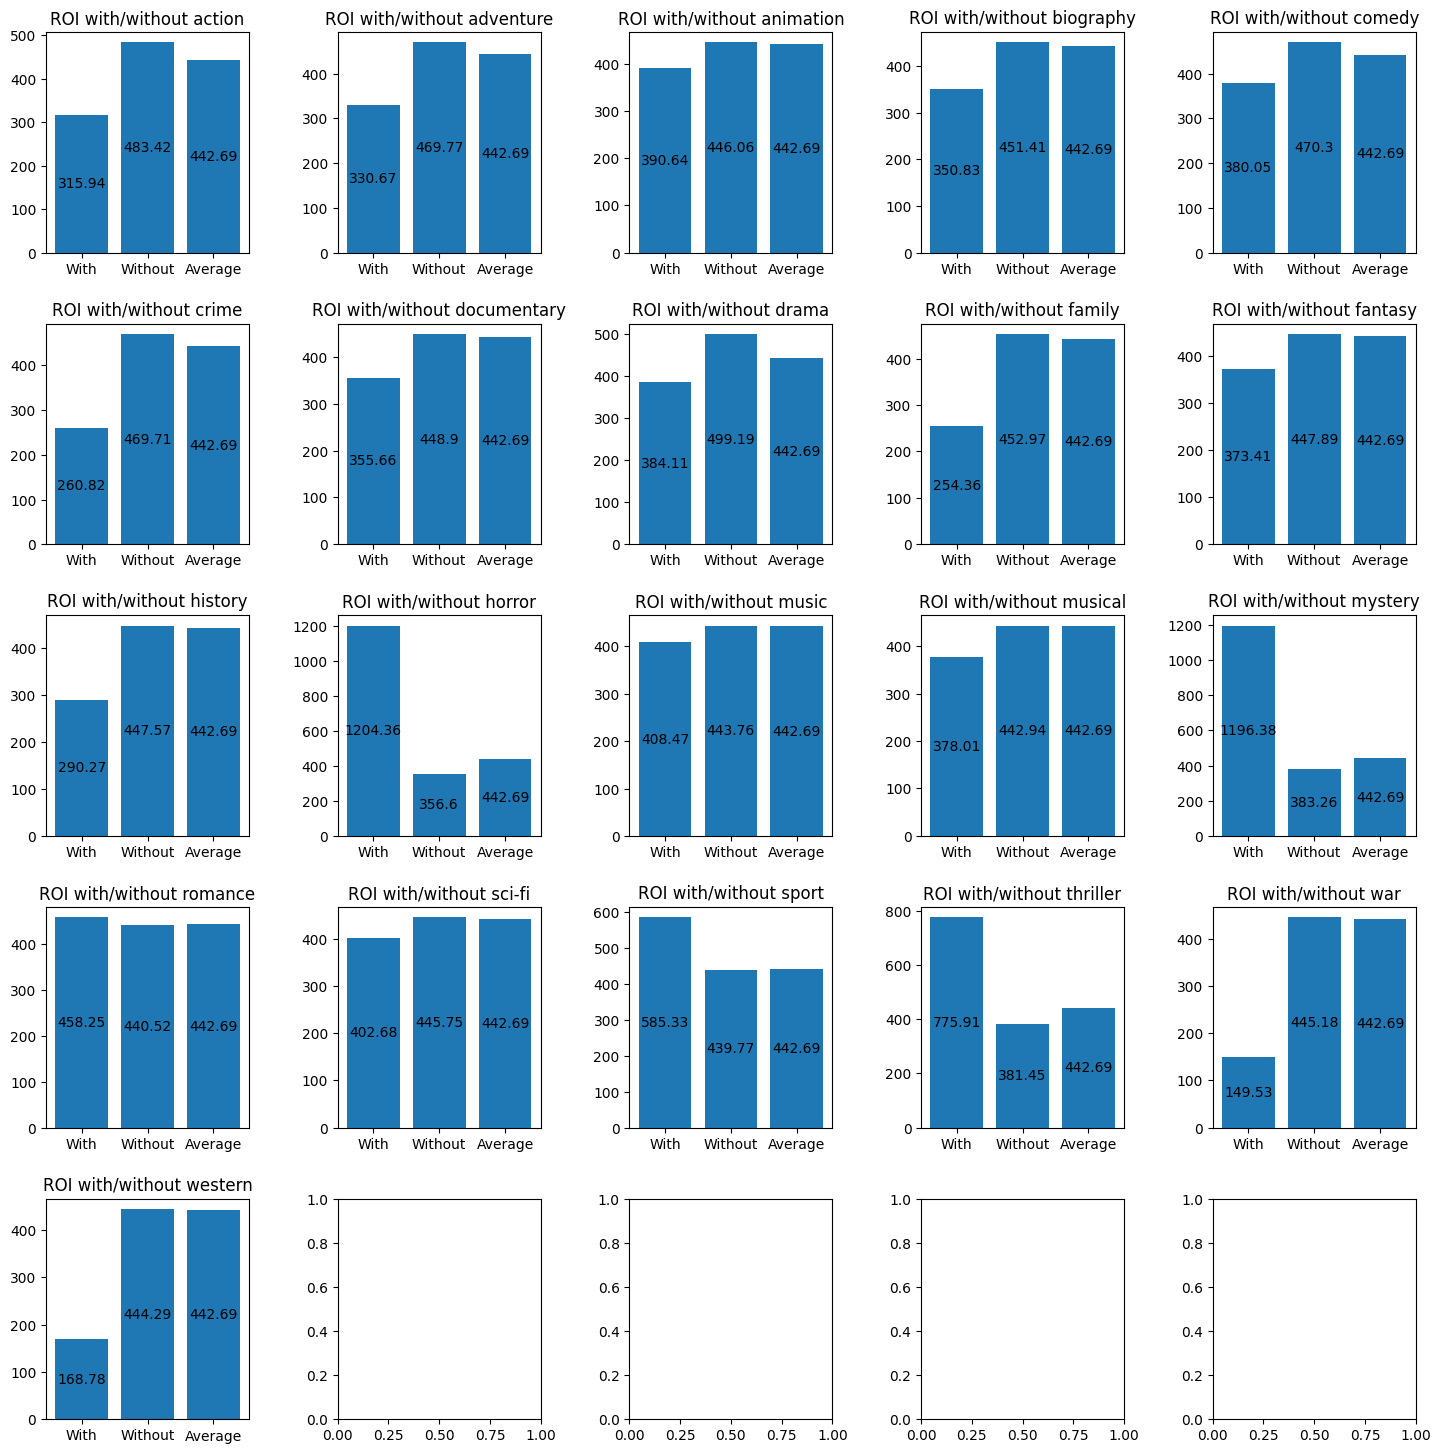

In [605]:
with_without_average = []

for i in range(len(genres)):
    on = df[df['is_' + genres[i]]==1]['ROI'].mean()
    off = df[df['is_' + genres[i]]==0]['ROI'].mean()
    average = df['ROI'].mean()
    with_without_average.append([on, off, average])
    

rows = 5
cols = 5

fig, ax = plt.subplots(rows,cols, figsize=(15,15))
fig.tight_layout(pad=3)

for i in range(rows*cols):
    
    try:
        row = i//rows
        col = i%rows

        x = ['With', 'Without', 'Average']
        y = with_without_average[i]
        ylabels=[round(i,2) for i in y]

        title = "ROI with/without {}".format(genres[i])
        ax[row,col].set_title(title)

        barplot = ax[row,col].bar(x,y)
        ax[row,col].bar_label(barplot, labels=ylabels, label_type='center');
        
    except:
        break

# Hitrate with or without the presence of a genre

For example, in the first graph, this means that action movies are 7% more likely to be profitable than non-action movies or your average movie. Likewise, adventure movies are 19% more likely to be profitable than non-adventure movies but only 16% more likely to be profitable than your average movie.

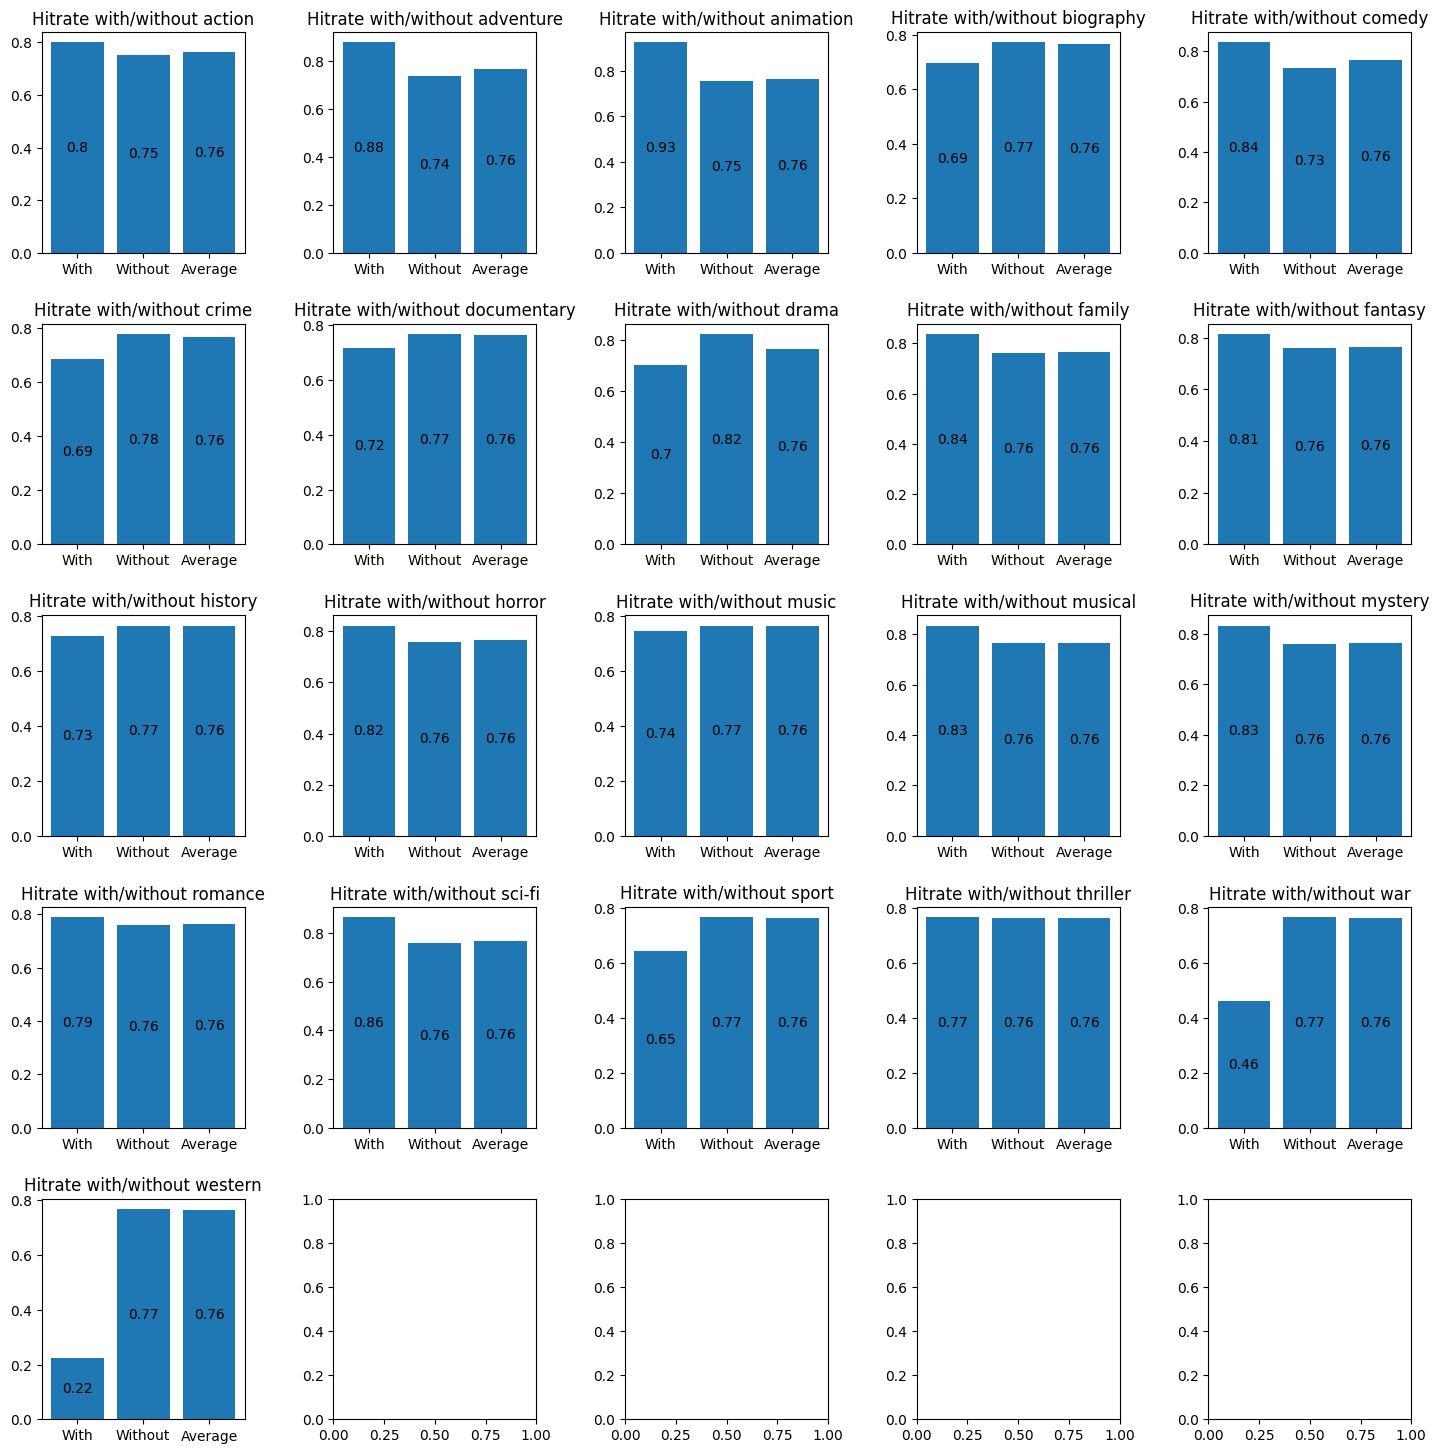

In [607]:
with_without_average=[]

for i in range(len(genres)):
    
    genre = genres[i]
    colname = "is_" + genre
    
    on = len(df[(df[colname]==1) & (df.positive_ROI==1)])/\
         len(df[(df[colname]==1)])
    
    off = len(df[(df[colname]==0) & (df.positive_ROI==1)])/\
          len(df[(df[colname]==0)])
    
    average = len(df[df.positive_ROI == 1])/\
              len(df)
    
    with_without_average.append([on,off,average])
    
    
    
rows = 5
cols = 5

fig, ax = plt.subplots(rows,cols, figsize=(15,15))
fig.tight_layout(pad=3)

for i in range(rows*cols):
    
    try:
        row = i//rows
        col = i%rows

        x = ['With', 'Without', 'Average']
        y = with_without_average[i]
        ylabels=[round(i,2) for i in y]

        title = "Hitrate with/without {}".format(genres[i])
        ax[row,col].set_title(title)

        barplot = ax[row,col].bar(x,y)
        ax[row,col].bar_label(barplot, labels=ylabels, label_type='center');
        
    except:
        break